# Hybrid Zero Shot Learning Approach

In [1]:
import pandas as pd
import numpy as np

<h2>Loading Pre-Trained Models</h2>

<h3>Loading BERT4RE</h3>

In [2]:
from transformers import AutoTokenizer, AutoModel

# Specify the model name for BERT4RE
model_name = "thearod5/bert4re"  # Replace with the correct model name or path if needed

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert4re = AutoModel.from_pretrained(model_name)

print("BERT4RE loaded successfully.")

Some weights of RobertaModel were not initialized from the model checkpoint at thearod5/bert4re and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT4RE loaded successfully.


<h3>Loading SBERT</h3>

In [3]:
from sentence_transformers import SentenceTransformer

# Load a pretrained SBERT model
model_name = "paraphrase-mpnet-base-v2" # Compatible with 768 Dimensions to match BERT4RE
sbert = SentenceTransformer(model_name)

print("SBERT model loaded successfully.")

SBERT model loaded successfully.


<h2>Data Preprocessing</h2>

<h3>Data Retrieval</h3>

In [4]:
# Loading in promise dataset
df = pd.read_csv("datasets/promise.csv")

df.head()

,INPUT,TYPE
0,The system shall refresh the display every 60 ...,PE
1,The application shall match the color of the s...,LF
2,If projected the data must be readable. On a...,US
3,The product shall be available during normal b...,A
4,If projected the data must be understandable....,US


<h3>Re-Labeling</h3>

In [5]:
# Making dataset binary between functional & non-functional requirements

df.loc[df['TYPE'] != 'F', 'TYPE'] = 'NF' # Locating all values that do not equal 'F' and changing them to 'NF'

df.head(20)

,INPUT,TYPE
0,The system shall refresh the display every 60 ...,NF
1,The application shall match the color of the s...,NF
2,If projected the data must be readable. On a...,NF
3,The product shall be available during normal b...,NF
4,If projected the data must be understandable....,NF
5,The product shall ensure that it can only be a...,NF
6,The product shall be intuitive and self-explan...,NF
7,The product shall respond fast to keep up-to-d...,NF
8,The system shall have a MDI form that allows f...,F
9,The system shall display Events in a vertical ...,F


<h3>Lowercasing</h3>

In [6]:
df['INPUT'] = df['INPUT'].str.lower()

df.head()

,INPUT,TYPE
0,the system shall refresh the display every 60 ...,NF
1,the application shall match the color of the s...,NF
2,if projected the data must be readable. on a...,NF
3,the product shall be available during normal b...,NF
4,if projected the data must be understandable....,NF


<h3>Stopword Removal</h3>

In [7]:
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()  # Split the text into words
    filtered_text = ' '.join([word for word in words if word.lower() not in stop_words])
    return filtered_text

# Apply stopword removal to the DataFrame column
df['INPUT'] = df['INPUT'].apply(remove_stopwords)

df.head()

,INPUT,TYPE
0,system shall refresh display every 60 seconds.,NF
1,application shall match color schema set forth...,NF
2,projected data must readable. 10x10 projection...,NF
3,product shall available normal business hours....,NF
4,projected data must understandable. 10x10 proj...,NF


<h3>Punctuation Removal<h3>

In [8]:
import string

# Replacing percent symbol to string
df['INPUT'] = df['INPUT'].str.replace('%', ' percent')

# Remove punctuation from a specific column (e.g., 'Column1')
df['INPUT'] = df['INPUT'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if isinstance(x, str) else x)

df.head(20)

,INPUT,TYPE
0,system shall refresh display every 60 seconds,NF
1,application shall match color schema set forth...,NF
2,projected data must readable 10x10 projection ...,NF
3,product shall available normal business hours ...,NF
4,projected data must understandable 10x10 proje...,NF
5,product shall ensure accessed authorized users...,NF
6,product shall intuitive selfexplanatory 90 pe...,NF
7,product shall respond fast keep uptodate data ...,NF
8,system shall mdi form allows viewing graph dat...,F
9,system shall display events vertical table time,F


<h3>Dataset Proportion</h3>

In [9]:
# Count the number of F and NF in the dataset
label_counts = df['TYPE'].value_counts()

print("Number of Functional (F) requirements:", label_counts.get('F', 0))
print("Number of Non-Functional (NF) requirements:", label_counts.get('NF', 0))

Number of Functional (F) requirements: 255
Number of Non-Functional (NF) requirements: 370


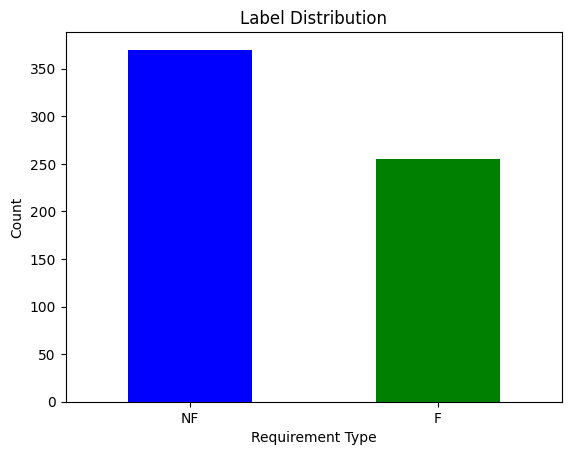

In [10]:
import matplotlib.pyplot as plt

# Plot a bar chart of label distribution
label_counts.plot(kind='bar', color=['blue', 'green'])
plt.title("Label Distribution")
plt.xlabel("Requirement Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

<h2>Fine-Tuning SBERT<h2>

<h3>SBERT Similarity Pairs</h3>

In [11]:
from sentence_transformers import InputExample

train_triplets = [
    # High similarity (F)
    InputExample(texts=[
        "Defines the actions the system must perform to meet user requirements.",  # Anchor
        "Specifies the user interactions needed to complete specific tasks.",      # Positive
        "Specifies usability standards to ensure the system is easy to navigate."  # Negative
    ]),
    InputExample(texts=[
        "Outlines workflows required to process data and handle transactions.",    # Anchor
        "Describes the steps the system follows to respond to user inputs.",       # Positive
        "Defines constraints for system operations, including memory and storage usage."  # Negative
    ]),
    InputExample(texts=[
        "Specifies how the system interacts with external services or APIs to fulfill tasks.",  # Anchor
        "Details the operations needed to retrieve and update information in the system.",      # Positive
        "Specifies how users can perform login tasks through the interface."                   # Negative
    ]),

    # High similarity (NF)
    InputExample(texts=[
        "Describes performance benchmarks like response time, throughput, and scalability.",  # Anchor
        "Specifies conditions for operating the system efficiently under load.",              # Positive
        "Specifies operations the system performs to process transactions."                   # Negative
    ]),
    InputExample(texts=[
        "Defines security measures to protect user data and system integrity.",               # Anchor
        "Outlines reliability requirements, such as uptime guarantees and error recovery.",   # Positive
        "Outlines the steps required to ensure operational safety and compliance."            # Negative
    ]),

    # Moderate similarity
    InputExample(texts=[
        "Describes the actions the system must perform to meet user requirements.",           # Anchor
        "Specifies how the system interacts with external services or APIs to fulfill tasks.",# Positive
        "Specifies the conditions to ensure the system operates securely and reliably."       # Negative
    ]),
    InputExample(texts=[
        "Details how the application validates user inputs before processing.",               # Anchor
        "Specifies how the system must interact with users to ensure task completion.",       # Positive
        "Defines how the system must calculate and process numerical data."                  # Negative
    ]),

    # Low similarity
    InputExample(texts=[
        "Defines security measures to protect user data and system integrity.",               # Anchor
        "Describes how the system processes user-provided information to produce results.",   # Positive
        "Specifies how users can perform login tasks through the interface."                  # Negative
    ]),
    InputExample(texts=[
        "Describes usability features to enhance the user interface experience.",             # Anchor
        "Defines the actions the system must perform to meet user requirements.",             # Positive
        "Ensures database backups occur every 24 hours."                                     # Negative
    ]),

    # Added distinctive pairs
    InputExample(texts=[
        "Executes business rules to calculate tax rates on transactions.",                    # Anchor
        "Implements logic to apply discounts and additional fees during payment processing.", # Positive
        "Describes strategies for ensuring uptime during system maintenance."                 # Negative
    ]),
    InputExample(texts=[
        "Ensures system throughput meets 100 transactions per second under peak load.",       # Anchor
        "Specifies memory consumption limits to maintain system responsiveness.",             # Positive
        "Outlines procedures to restore services in under 10 minutes after a crash."          # Negative
    ])
]

<h3>SBERT Tuning</h3>

In [12]:
from sentence_transformers import losses
from torch.utils.data import DataLoader

# Prepare train set (assuming train_triplets is already prepared)
train_dataloader = DataLoader(train_triplets, shuffle=True, batch_size=16)

# Define triplet loss
triplet_loss = losses.TripletLoss(
    model=sbert, 
    distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE
)

# Fine-tune the SBERT model
sbert.fit(
    train_objectives=[(train_dataloader, triplet_loss)],
    epochs=20,  # Adjust as needed
    warmup_steps=100,  # Adjust as needed
    output_path="./tuned_sbert",  # Path to save the model
    show_progress_bar=True
)

# Save the fine-tuned model
sbert.save("./tuned_sbert")


Step,Training Loss


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

<h3>Loading Tuned SBERT</h3>

In [13]:
# Path to the fine-tuned model
model_path = "./tuned_sbert"

# Load the fine-tuned model
tuned_sbert = SentenceTransformer(model_path)
print("Fine-tuned SBERT model loaded successfully.")

Fine-tuned SBERT model loaded successfully.


<h3>Label Descriptions</h3>

In [14]:
# Label descriptions for Functional and Non-Functional

label_descriptions = {
    "F": [
        "Defines the specific steps the system takes to process user inputs.",
        "Outlines the workflows needed to complete user-requested tasks.",
        "Specifies operations the system performs to deliver its core functionality.",
        "Describes actions required to retrieve and update data in response to user commands."
    ],
    "NF": [
        "Defines performance benchmarks for reliability, speed, and scalability.",
        "Specifies the maximum allowable downtime during maintenance periods.",
        "Describes constraints on memory usage under normal and peak conditions.",
        "Ensures data is processed within predefined latency benchmarks.",
    ]
}

<h3>SBERT Label Description Embeddings</h3>

In [15]:
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute SBERT embeddings for each label description
sbert_label_embeddings = {
    label: [tuned_sbert.encode(desc, convert_to_tensor=True).to(device) for desc in descriptions]
    for label, descriptions in label_descriptions.items()
}

# Calculate intra-label cosine similarities
intra_label_similarity = {}

for label, embeddings in sbert_label_embeddings.items():
    # Convert embeddings to numpy arrays
    embeddings_np = [embedding.detach().cpu().numpy() for embedding in embeddings]
    
    # Compute pairwise cosine similarities
    pairwise_sim = cosine_similarity(embeddings_np)
    
    # Extract the upper triangle of the similarity matrix (excluding diagonal)
    upper_triangle = pairwise_sim[np.triu_indices_from(pairwise_sim, k=1)]
    
    # Compute the mean similarity for the label
    intra_label_similarity[label] = upper_triangle.mean()

    print(f"Mean intra-label cosine similarity for {label}: {intra_label_similarity[label]:.4f}")

# Compute inter-label cosine similarity (F vs NF)
f_embedding = torch.stack(sbert_label_embeddings["F"]).mean(dim=0).detach().cpu().numpy()
nf_embedding = torch.stack(sbert_label_embeddings["NF"]).mean(dim=0).detach().cpu().numpy()
cos_sim_inter = cosine_similarity([f_embedding], [nf_embedding])[0][0]

print(f"\nCosine similarity between SBERT F and NF embeddings: {cos_sim_inter:.4f}")


Mean intra-label cosine similarity for F: 0.6073
Mean intra-label cosine similarity for NF: 0.3984

Cosine similarity between SBERT F and NF embeddings: 0.3611


<h3>Visualizing SBERT Embedding Space</h3>

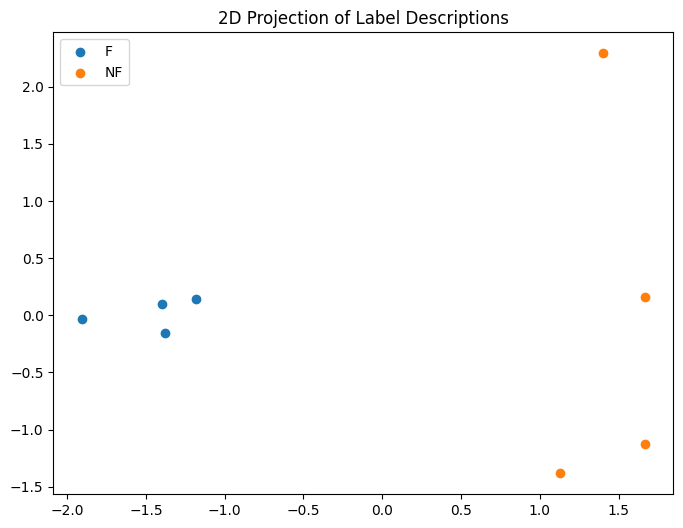

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Combine F and NF embeddings
combined_embeddings = [emb.detach().cpu().numpy() for emb in sbert_label_embeddings["F"]] + \
                      [emb.detach().cpu().numpy() for emb in sbert_label_embeddings["NF"]]
labels = ["F"] * len(sbert_label_embeddings["F"]) + ["NF"] * len(sbert_label_embeddings["NF"])

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(combined_embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 6))
for label in set(labels):
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=label)
plt.legend()
plt.title("2D Projection of Label Descriptions")
plt.show()

<h3>BERT4RE Requirements Embeddings</h3>

In [17]:
# Split dataset into Functional and Non-Functional

functional_requirements = df[df['TYPE'] == 'F']
non_functional_requirements = df[df['TYPE'] == 'NF']

functional_embeddings = []
non_functional_embeddings = []

for text in functional_requirements['INPUT']:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        bert4re_embedding = bert4re(**inputs).last_hidden_state[:, 0, :]  # CLS pooling
        functional_embeddings.append(bert4re_embedding.cpu())

for text in non_functional_requirements['INPUT']:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        bert4re_embedding = bert4re(**inputs).last_hidden_state[:, 0, :]  # CLS pooling
        non_functional_embeddings.append(bert4re_embedding.cpu())

# Stack embeddings into tensors
functional_embeddings = torch.stack(functional_embeddings)
non_functional_embeddings = torch.stack(non_functional_embeddings)

print("BERT4RE Requirement Embeddings Generated")

BERT4RE Requirement Embeddings Generated


<h3>Normalization</h3>

In [18]:
# Normalize embeddings to unit vectors
functional_embeddings = torch.nn.functional.normalize(functional_embeddings, p=2, dim=1)
non_functional_embeddings = torch.nn.functional.normalize(non_functional_embeddings, p=2, dim=1)

<h2>Model Evaluation & Accuracy</h2>

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Ensure functional_embeddings and non_functional_embeddings are tensors
functional_embeddings = torch.stack([embed.clone().detach() for embed in functional_embeddings])
non_functional_embeddings = torch.stack([embed.clone().detach() for embed in non_functional_embeddings])

# Ensure functional_embeddings and non_functional_embeddings are tensors
functional_embeddings = torch.stack([torch.tensor(embed) for embed in functional_embeddings])
non_functional_embeddings = torch.stack([torch.tensor(embed) for embed in non_functional_embeddings])

# Ensure that sbert_label_embeddings values are tensors
label_embeddings = {
    label: torch.mean(torch.stack(embs), dim=0).detach().numpy()  # Stack, average, and convert to numpy
    if isinstance(embs, list) else embs.detach().numpy()
    for label, embs in sbert_label_embeddings.items()
}

# Combine BERT4RE embeddings for Functional and Non-Functional
all_embeddings = torch.cat([functional_embeddings, non_functional_embeddings], dim=0).detach().numpy()
true_labels = ['F'] * len(functional_embeddings) + ['NF'] * len(non_functional_embeddings)

# Classification using cosine similarity
predictions = []
for embedding in all_embeddings:
    # Compute similarity with SBERT label embeddings
    f_similarity = cosine_similarity(embedding.reshape(1, -1), label_embeddings['F'].reshape(1, -1))[0][0]
    nf_similarity = cosine_similarity(embedding.reshape(1, -1), label_embeddings['NF'].reshape(1, -1))[0][0]

    # Predict class based on higher similarity
    if f_similarity > nf_similarity:
        predictions.append('F')
    else:
        predictions.append('NF')

# Evaluate the results
accuracy = accuracy_score(true_labels, predictions)
classification_results = classification_report(true_labels, predictions, target_names=['F', 'NF'])

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_results)


/tmp/ipykernel_50171/1274412600.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  functional_embeddings = torch.stack([torch.tensor(embed) for embed in functional_embeddings])
/tmp/ipykernel_50171/1274412600.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  non_functional_embeddings = torch.stack([torch.tensor(embed) for embed in non_functional_embeddings])


Accuracy: 0.4384
Classification Report:
              precision    recall  f1-score   support

           F       0.42      0.97      0.59       255
          NF       0.79      0.07      0.13       370

    accuracy                           0.44       625
   macro avg       0.60      0.52      0.36       625
weighted avg       0.64      0.44      0.32       625



: 